In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from matplotlib.colors import LogNorm
from scipy.integrate import odeint
sns.set_context("talk", font_scale=1.4)

# for using LaTeX fonts
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

## Compute the temporal development from the transition matrix
### Load some data

In [2]:
# load the transition matrix
P_allCountries_Bayes = np.genfromtxt('./../results/transitionBayesAllCountries.csv')

In [3]:
# Load the time series for plotting empirical distributions
timeSeries = pd.read_excel('./../data/polity5/p5v2018.xls')
# do some cleaning
timeSeries = timeSeries.dropna(subset=['year', 'country', 'polity2'])

### Actual computations

In [4]:
# Get the distribution for the year 2018
currentScores=timeSeries[timeSeries['year']==2018]['polity2']
[counts2018,bins] = np.histogram(currentScores,bins=np.arange(-10,12))
density2018 = counts2018/np.sum(counts2018)

In [5]:
# iterate over years 

tMax = 750

# forward
x=np.zeros((21,tMax))
x[:,0]=density2018
for t in np.arange(tMax-1):
    x[:,t+1]= x[:,t].dot(P_allCountries_Bayes)

In [6]:
# We also need the steady state again for the illustration
def computeSteadyStateEV(transitionMatrix):
    # compute it as eigenvector
    valsT, vecsT = np.linalg.eig(transitionMatrix.transpose())
    
    # find the index of the eigenvalue closest to 1
    index_ev1 = (np.abs(valsT - 1)).argmin()
    
    v = vecsT[:,index_ev1]
    return((v/np.sum(v)).real) # normalise it for the return and also ignore the imaginary part (from numerical approx.)



steadyStateB = computeSteadyStateEV(P_allCountries_Bayes)

## Illustrations

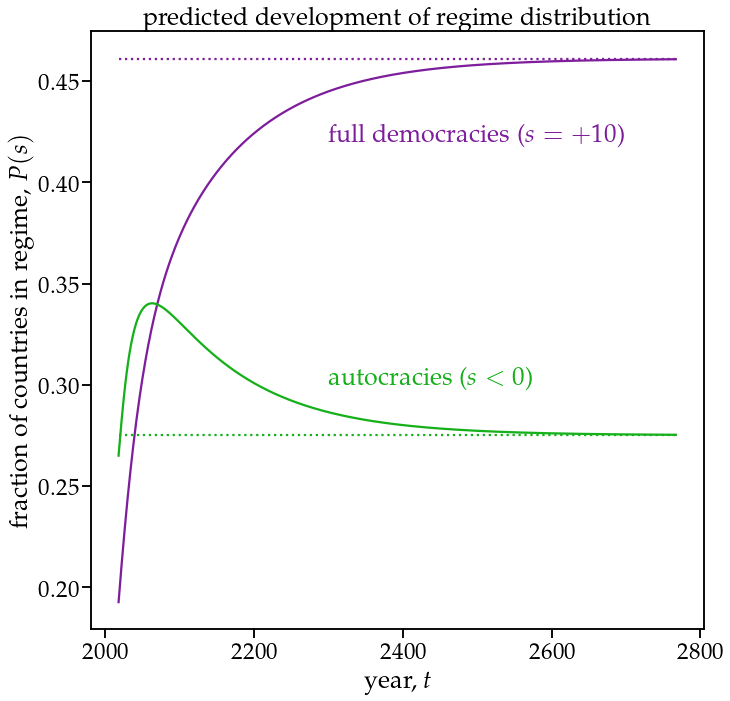

In [8]:
plt.figure(figsize=(11,11))
# plot the full democracy fraction
plt.plot(np.arange(2018, 2018+ tMax),x[20,:],c=sns.xkcd_rgb['purple'])

# plot the autocracies
autocraty = np.sum(x[0:10,:],axis=0)
plt.plot(np.arange(2018, 2018+ tMax),autocraty,c=sns.xkcd_rgb['green'])


# Plot steady state lines
plt.hlines(y=steadyStateB[20],xmin=2018,xmax=2018+tMax,linestyles='dotted',color=sns.xkcd_rgb['purple'])
plt.hlines(y=np.sum(steadyStateB[0:10]),xmin=2018,xmax=2018+tMax,linestyles='dotted',color=sns.xkcd_rgb['green'])


# add labels
plt.text(x=2300,y=0.3,s=r'autocracies ($s<0$)',color=sns.xkcd_rgb['green'])
plt.text(x=2300,y=0.42,s=r'full democracies ($s=+10$)',color=sns.xkcd_rgb['purple'])
plt.xlabel(r'year, $t$')
plt.ylabel(r'fraction of countries in regime, $P(s)$')
plt.title('predicted development of regime distribution')
plt.savefig('./../results/figures/Fig5-predictedDevelopment.pdf',bbox_inches='tight')
